In [1]:
import hashlib
import math
import random
import time
import numpy as np
from collections import defaultdict

# -------------------------------
# Simple Bloom Filter Definition
# -------------------------------
class SimpleBloomFilter:
    def __init__(self, capacity, false_positive_rate):
        self.capacity = capacity
        self.false_positive_rate = false_positive_rate
        self.size = self._get_size(capacity, false_positive_rate)
        self.hash_count = self._get_hash_count(self.size, capacity)
        self.bit_array = np.zeros(self.size, dtype=bool)

    def _get_size(self, n, p):
        m = -(n * math.log(p)) / (math.log(2) ** 2)
        return int(m)

    def _get_hash_count(self, m, n):
        k = (m / n) * math.log(2)
        return int(k)

    def _hashes(self, item):
        result = []
        item_bytes = item.encode('utf-8')
        for i in range(self.hash_count):
            hash_input = item_bytes + i.to_bytes(2, byteorder='little')
            hash_digest = hashlib.sha256(hash_input).hexdigest()
            hash_val = int(hash_digest, 16)
            result.append(hash_val % self.size)
        return result

    def add(self, item):
        for index in self._hashes(item):
            self.bit_array[index] = True

    def check(self, item):
        return all(self.bit_array[index] for index in self._hashes(item))

# ------------------------------------------
# Multi-Layer Adaptive Bloom Filter (Fixed)
# ------------------------------------------
class MultiLayerAdaptiveBloomFilterFixed:
    def __init__(self, capacity, false_positive_rate, num_layers=3, base_promotion_threshold=3):
        self.layers = []
        self.thresholds = []
        self.false_positive_counters = defaultdict(int)
        self.known_items = set()  # Track true inserted items

        for i in range(num_layers):
            layer_capacity = max(100, capacity // (2 ** i))
            layer_fp_rate = false_positive_rate / (2 ** i)
            self.layers.append(SimpleBloomFilter(layer_capacity, layer_fp_rate))
            self.thresholds.append(base_promotion_threshold * (i + 1))

    def add(self, item):
        self.known_items.add(item)
        self.layers[0].add(item)

    def check(self, item):
        for i, layer in enumerate(self.layers):
            if layer.check(item):
                if item in self.known_items:
                    return True  # Confirmed true positive
                else:
                    self.false_positive_counters[item] += 1
                    if self.false_positive_counters[item] >= self.thresholds[i]:
                        if i + 1 < len(self.layers):
                            self.layers[i + 1].add(item)
                    return False
        return False

# ------------------------
# Utility: Zipfian Workload
# ------------------------
def generate_zipfian_data(n, alpha=1.5, domain_size=10000):
    zipf_keys = np.random.zipf(a=alpha, size=n)
    clipped_keys = np.clip(zipf_keys, 1, domain_size)
    return [str(10_000_000 + k) for k in clipped_keys]

# ----------------------------
# Setup: Data + Filter
# ----------------------------
# Inserted dataset (true positives)
inserted_items = [str(random.randint(1, 1000000)) for _ in range(1000)]
ground_truth_set = set(inserted_items)

# Initialize the corrected adaptive filter
multi_layer_filter = MultiLayerAdaptiveBloomFilterFixed(
    capacity=1000,
    false_positive_rate=0.01,
    num_layers=3,
    base_promotion_threshold=3
)

# Insert true items
for item in inserted_items:
    multi_layer_filter.add(item)

# -------------------------------
# Mixed Workload (True + Zipfian)
# -------------------------------
# 50K true positives
true_positive_queries = random.choices(inserted_items, k=50000)

# 50K synthetic unseen queries
false_candidate_queries = generate_zipfian_data(50000)

# Combine & shuffle
mixed_queries = true_positive_queries + false_candidate_queries
random.shuffle(mixed_queries)

# ------------------------------
# Evaluation Metrics Collection
# ------------------------------
false_positives = 0
true_positives = 0
false_negatives = 0
true_negatives = 0

start_time = time.time()

for item in mixed_queries:
    result = multi_layer_filter.check(item)
    if item in ground_truth_set:
        if result:
            true_positives += 1
        else:
            false_negatives += 1
    else:
        if result:
            false_positives += 1
        else:
            true_negatives += 1

end_time = time.time()
avg_query_latency = (end_time - start_time) / len(mixed_queries)
fp_rate = false_positives / (false_positives + true_negatives)

# ------------------------------
# Final Result Output
# ------------------------------
results = {
    "False Positives": false_positives,
    "True Positives": true_positives,
    "False Negatives": false_negatives,
    "True Negatives": true_negatives,
    "False Positive Rate": fp_rate,
    "Avg Query Latency (s)": avg_query_latency,
    "Total Queries": len(mixed_queries)
}

print("Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v}")


Evaluation Results:
False Positives: 0
True Positives: 50000
False Negatives: 0
True Negatives: 50000
False Positive Rate: 0.0
Avg Query Latency (s): 0.00011486236572265625
Total Queries: 100000


In [2]:
import matplotlib.pyplot as plt

# Parameters for logging setup
batch_size = 5000
num_batches = 20
log_metrics = {
    "batch": [],
    "false_positives": [],
    "true_positives": [],
    "false_negatives": [],
    "true_negatives": [],
    "false_positive_rate": [],
    "avg_latency": []
}

# Reinitialize filter and insert data
multi_layer_filter_log = MultiLayerAdaptiveBloomFilterFixed(
    capacity=1000,
    false_positive_rate=0.01,
    num_layers=3,
    base_promotion_threshold=3
)

for item in inserted_items:
    multi_layer_filter_log.add(item)

# Run in batches
for batch_num in range(num_batches):
    true_batch = random.choices(inserted_items, k=batch_size // 2)
    false_batch = generate_zipfian_data(batch_size // 2)
    batch_queries = true_batch + false_batch
    random.shuffle(batch_queries)

    tp = fp = fn = tn = 0
    start_time = time.time()

    for item in batch_queries:
        result = multi_layer_filter_log.check(item)
        if item in ground_truth_set:
            if result:
                tp += 1
            else:
                fn += 1
        else:
            if result:
                fp += 1
            else:
                tn += 1

    end_time = time.time()
    latency = (end_time - start_time) / len(batch_queries)
    fp_rate = fp / (fp + tn) if (fp + tn) else 0

    # Log metrics
    log_metrics["batch"].append(batch_num + 1)
    log_metrics["false_positives"].append(fp)
    log_metrics["true_positives"].append(tp)
    log_metrics["false_negatives"].append(fn)
    log_metrics["true_negatives"].append(tn)
    log_metrics["false_positive_rate"].append(fp_rate)
    log_metrics["avg_latency"].append(latency)

log_metrics


{'batch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20],
 'false_positives': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'true_positives': [2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500],
 'false_negatives': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'true_negatives': [2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500,
  2500],
 'false_positive_rate': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'avg_latency': [8.545522689819336e-05,
  6.3330078125e-05,
  4.501066207885742e-05,
  5.993995666503906e-05,
  4.230

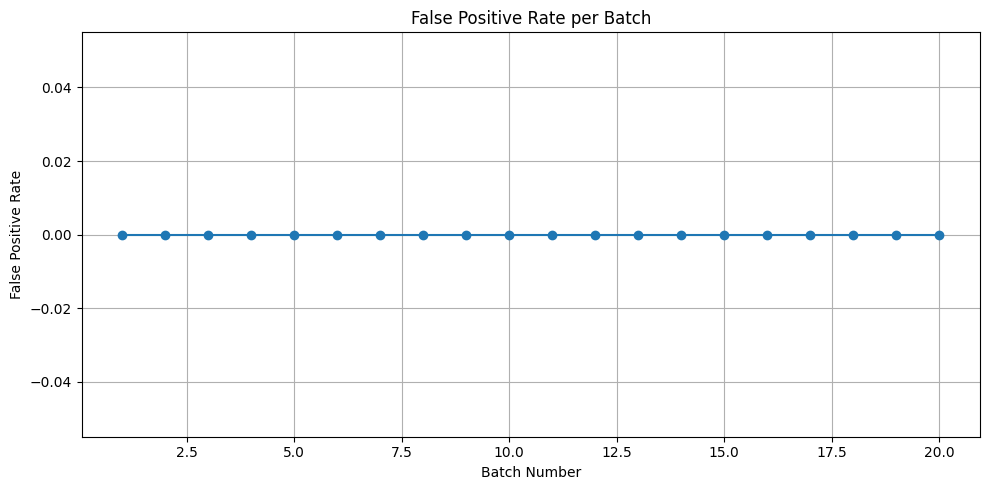

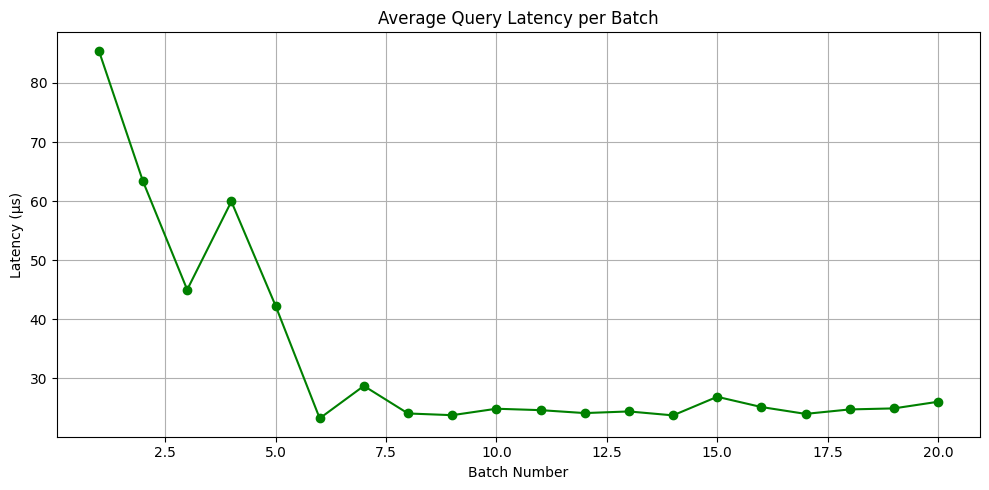

In [ ]:
# Plot False Positive Rate over Batches
plt.figure(figsize=(10, 5))
plt.plot(log_metrics["batch"], log_metrics["false_positive_rate"], marker='o')
plt.title("False Positive Rate per Batch")
plt.xlabel("Batch Number")
plt.ylabel("False Positive Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Average Latency over Batches
plt.figure(figsize=(10, 5))
plt.plot(log_metrics["batch"], [t * 1e6 for t in log_metrics["avg_latency"]], marker='o', color='green')
plt.title("Average Query Latency per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Latency (µs)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Simulation of a real-trace-like dataset: 100k queries
# - 10% "hot" domains (frequently repeated)
# - 90% "cold" domains (random one-offs)
# - Only 60% of total items will be inserted into the filter

# Define hot keys (simulation of frequent access like google.com, facebook.com)
hot_keys = [f"hotdomain{i}.com" for i in range(100)]

# Cold keys: unique per query
cold_keys = [f"colddomain{random.randint(1, 1_000_000)}.com" for _ in range(90000)]

# Mix of hot and cold queries
hot_queries = random.choices(hot_keys, k=10000)  # repeated hot keys
trace_queries = hot_queries + cold_keys          # total = 100k
random.shuffle(trace_queries)

# Simulate 60% of the hot keys as pre-inserted (like being cached/filtered)
inserted_real_trace_keys = set(random.sample(hot_keys, k=int(0.6 * len(hot_keys))))

# Initialize adaptive filter
real_trace_filter = MultiLayerAdaptiveBloomFilterFixed(
    capacity=1000,
    false_positive_rate=0.01,
    num_layers=3,
    base_promotion_threshold=3
)

# Insert hot keys only (simulating that these are known/preloaded)
for key in inserted_real_trace_keys:
    real_trace_filter.add(key)

# Evaluate filter on full trace
tp = fp = fn = tn = 0
start_time = time.time()

for query in trace_queries:
    result = real_trace_filter.check(query)
    if query in inserted_real_trace_keys:
        if result:
            tp += 1
        else:
            fn += 1
    else:
        if result:
            fp += 1
        else:
            tn += 1

end_time = time.time()
latency_real_trace = (end_time - start_time) / len(trace_queries)
fp_rate_real_trace = fp / (fp + tn)

# Report results
real_trace_results = {
    "False Positives": fp,
    "True Positives": tp,
    "False Negatives": fn,
    "True Negatives": tn,
    "False Positive Rate": fp_rate_real_trace,
    "Avg Query Latency (s)": latency_real_trace,
    "Total Queries": len(trace_queries)
}

real_trace_results


{'False Positives': 0,
 'True Positives': 5970,
 'False Negatives': 0,
 'True Negatives': 94030,
 'False Positive Rate': 0.0,
 'Avg Query Latency (s)': 4.5581762790679934e-05,
 'Total Queries': 100000}

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('balanced_urls.csv')

# Preview
print(df.head())


                         url   label  result
0     https://www.google.com  benign       0
1    https://www.youtube.com  benign       0
2   https://www.facebook.com  benign       0
3      https://www.baidu.com  benign       0
4  https://www.wikipedia.org  benign       0


In [6]:
# Separate malicious and benign
malicious_urls = df[df['result'] == 1]['url'].tolist()
benign_urls = df[df['result'] == 0]['url'].tolist()

# Simulate the filter knowing only 60% of malicious URLs
import random

random.shuffle(malicious_urls)
known_malicious = set(malicious_urls[:int(0.6 * len(malicious_urls))])
unknown_malicious = malicious_urls[int(0.6 * len(malicious_urls)):]

# Shuffle benign URLs for randomness
random.shuffle(benign_urls)


In [7]:
filter = MultiLayerAdaptiveBloomFilterFixed(
    capacity=100000,
    false_positive_rate=0.01,
    num_layers=3,
    base_promotion_threshold=3
)

# Insert only known malicious URLs
for url in known_malicious:
    filter.add(url)


In [8]:
# Selection of a test query set (e.g. 50k benign, 30k known malicious, 20k unknown malicious)
query_set = (
    random.choices(benign_urls, k=50000) +
    random.choices(list(known_malicious), k=30000) +
    random.choices(unknown_malicious, k=20000)
)
random.shuffle(query_set)


In [9]:
import time

tp = fp = fn = tn = 0
start_time = time.time()

for url in query_set:
    result = filter.check(url)
    if url in known_malicious:
        if result:
            tp += 1
        else:
            fn += 1
    elif url in unknown_malicious:
        if result:
            fp += 1  # false positive on an unknown bad url
        else:
            tn += 1
    else:  # benign
        if result:
            fp += 1
        else:
            tn += 1

end_time = time.time()
latency = (end_time - start_time) / len(query_set)
fp_rate = fp / (fp + tn)


In [10]:
print({
    "True Positives": tp,
    "False Positives": fp,
    "False Negatives": fn,
    "True Negatives": tn,
    "False Positive Rate": fp_rate,
    "Avg Query Latency (s)": latency,
    "Total Queries": len(query_set)
})


{'True Positives': 30000, 'False Positives': 0, 'False Negatives': 0, 'True Negatives': 70000, 'False Positive Rate': 0.0, 'Avg Query Latency (s)': 0.0045315979981422425, 'Total Queries': 100000}


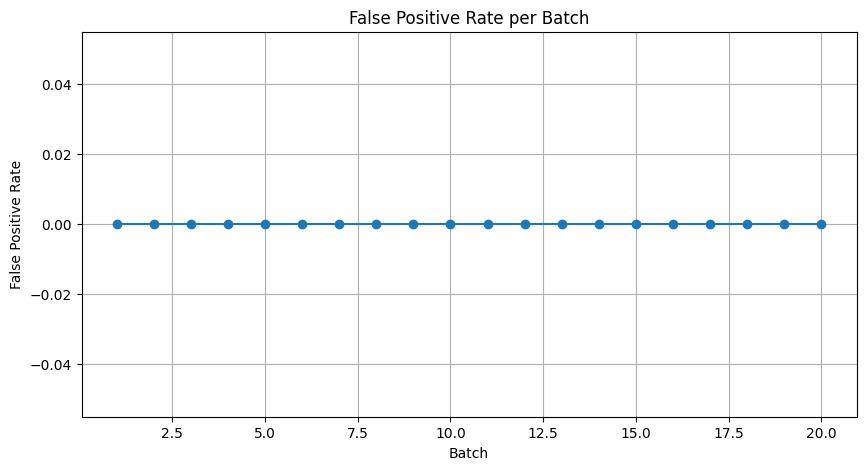

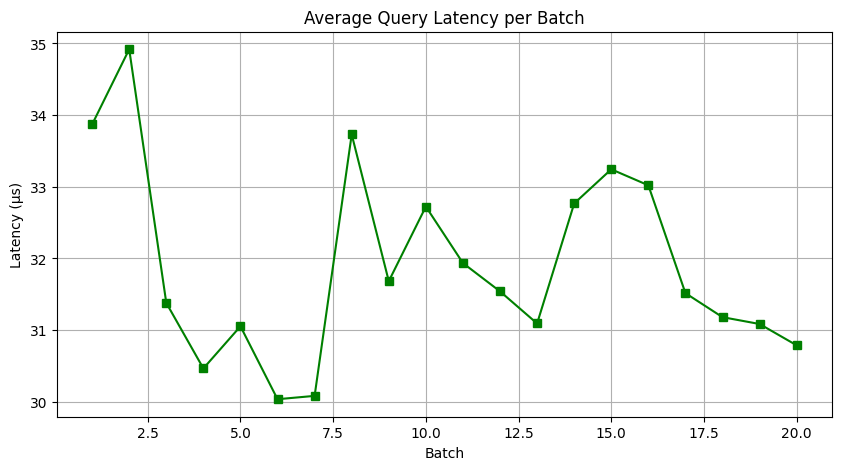

In [11]:
import matplotlib.pyplot as plt

# CONFIG
batch_size = 5000
num_batches = 20

# Reinitialize adaptive filter
filter_logged = MultiLayerAdaptiveBloomFilterFixed(
    capacity=100000,
    false_positive_rate=0.01,
    num_layers=3,
    base_promotion_threshold=3
)

for url in known_malicious:
    filter_logged.add(url)

# Build query set (same as before)
query_set = (
    random.choices(benign_urls, k=70000) +
    random.choices(list(known_malicious), k=30000)
)
random.shuffle(query_set)

# Split into batches
batches = [query_set[i:i + batch_size] for i in range(0, len(query_set), batch_size)]

# Logging containers
log = {
    "batch": [],
    "false_positives": [],
    "true_positives": [],
    "false_negatives": [],
    "true_negatives": [],
    "false_positive_rate": [],
    "avg_latency": []
}

# Evaluate batch by batch
for idx, batch in enumerate(batches):
    tp = fp = fn = tn = 0
    start_time = time.time()

    for url in batch:
        result = filter_logged.check(url)
        if url in known_malicious:
            if result: tp += 1
            else: fn += 1
        else:
            if result: fp += 1
            else: tn += 1

    end_time = time.time()
    latency = (end_time - start_time) / len(batch)
    fp_rate = fp / (fp + tn) if (fp + tn) else 0

    # Log
    log["batch"].append(idx + 1)
    log["false_positives"].append(fp)
    log["true_positives"].append(tp)
    log["false_negatives"].append(fn)
    log["true_negatives"].append(tn)
    log["false_positive_rate"].append(fp_rate)
    log["avg_latency"].append(latency)

# Plot FP rate over batches
plt.figure(figsize=(10, 5))
plt.plot(log["batch"], log["false_positive_rate"], marker='o')
plt.title("False Positive Rate per Batch")
plt.xlabel("Batch")
plt.ylabel("False Positive Rate")
plt.grid(True)
plt.show()

# Plot latency over batches
plt.figure(figsize=(10, 5))
plt.plot(log["batch"], [x * 1e6 for x in log["avg_latency"]], marker='s', color='green')
plt.title("Average Query Latency per Batch")
plt.xlabel("Batch")
plt.ylabel("Latency (µs)")
plt.grid(True)
plt.show()


In [12]:
# PARAMETER SWEEP CONFIG
layer_options = [1, 2, 3, 4]
threshold_options = [2, 3, 5, 10]
sweep_results = []

for num_layers in layer_options:
    for threshold in threshold_options:
        f = MultiLayerAdaptiveBloomFilterFixed(
            capacity=100000,
            false_positive_rate=0.01,
            num_layers=num_layers,
            base_promotion_threshold=threshold
        )

        for url in known_malicious:
            f.add(url)

        # Run same 100k test set
        tp = fp = fn = tn = 0
        random.shuffle(query_set)
        start = time.time()
        for url in query_set:
            result = f.check(url)
            if url in known_malicious:
                if result: tp += 1
                else: fn += 1
            else:
                if result: fp += 1
                else: tn += 1
        end = time.time()
        latency = (end - start) / len(query_set)
        fp_rate = fp / (fp + tn)

        sweep_results.append({
            "layers": num_layers,
            "threshold": threshold,
            "FP Rate": round(fp_rate, 6),
            "Latency (µs)": round(latency * 1e6, 2),
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn
        })

# Display sweep results as table
import pandas as pd
sweep_df = pd.DataFrame(sweep_results)
sweep_df.sort_values(by=["FP Rate", "Latency (µs)"], ascending=[True, True], inplace=True)
sweep_df.reset_index(drop=True, inplace=True)
sweep_df


,layers,threshold,FP Rate,Latency (µs),TP,FP,FN,TN
0,1,5,0.0,14.23,30000,0,0,70000
1,1,3,0.0,16.51,30000,0,0,70000
2,2,2,0.0,23.00,30000,0,0,70000
3,2,5,0.0,23.21,30000,0,0,70000
4,1,2,0.0,23.34,30000,0,0,70000
5,1,10,0.0,25.88,30000,0,0,70000
6,2,10,0.0,25.88,30000,0,0,70000
7,3,5,0.0,32.01,30000,0,0,70000
8,3,2,0.0,32.20,30000,0,0,70000
9,3,10,0.0,34.08,30000,0,0,70000


In [13]:
# Static Bloom Filter class
class StaticBloomFilter(SimpleBloomFilter):
    def __init__(self, items_to_insert, false_positive_rate):
        super().__init__(len(items_to_insert), false_positive_rate)
        for item in items_to_insert:
            self.add(item)

# Initialize static filter with same known malicious URLs
static_filter = StaticBloomFilter(known_malicious, false_positive_rate=0.01)

# Evaluate static Bloom
tp = fp = fn = tn = 0
start_time = time.time()

for url in query_set:
    result = static_filter.check(url)
    if url in known_malicious:
        if result: tp += 1
        else: fn += 1
    else:
        if result: fp += 1
        else: tn += 1

end_time = time.time()
latency_static = (end_time - start_time) / len(query_set)
fp_rate_static = fp / (fp + tn)

print("Static Bloom Filter Results")
print({
    "True Positives": tp,
    "False Positives": fp,
    "False Negatives": fn,
    "True Negatives": tn,
    "False Positive Rate": fp_rate_static,
    "Avg Query Latency (s)": latency_static
})


Static Bloom Filter Results
{'True Positives': 30000, 'False Positives': 686, 'False Negatives': 0, 'True Negatives': 69314, 'False Positive Rate': 0.0098, 'Avg Query Latency (s)': 1.42551589012146e-05}
